#Importing Libraries

In [3]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

#Loading Data

In [4]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [5]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [6]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

#Feature Engineering

In [7]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


#One hot encoding

In [9]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [10]:
print(X[0][0])

[False False False ... False False False]


#Building the Model

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

#Training data

In [12]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


811/811 [==============================] - 263s 322ms/step - loss: 6.0103 - accuracy: 0.1067 - val_loss: 7.0471 - val_accuracy: 0.1014
Epoch 2/10
811/811 [==============================] - 248s 306ms/step - loss: 5.7653 - accuracy: 0.1476 - val_loss: 7.9336 - val_accuracy: 0.1077
Epoch 3/10
811/811 [==============================] - 248s 306ms/step - loss: 5.7562 - accuracy: 0.1765 - val_loss: 8.1242 - val_accuracy: 0.1034
Epoch 4/10
811/811 [==============================] - 247s 305ms/step - loss: 5.4525 - accuracy: 0.2096 - val_loss: 8.0976 - val_accuracy: 0.1047
Epoch 5/10
811/811 [==============================] - 245s 302ms/step - loss: 5.1508 - accuracy: 0.2455 - val_loss: 8.2239 - val_accuracy: 0.0934
Epoch 6/10
811/811 [==============================] - 246s 304ms/step - loss: 4.9085 - accuracy: 0.2843 - val_loss: 8.5737 - val_accuracy: 0.0926
Epoch 7/10
811/811 [==============================] - 247s 304ms/step - loss: 4.6635 - accuracy: 0.3226 - val_loss: 8.6574 - val_accura

#Saving the model and reloading

In [13]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [14]:
history

{'loss': [6.010300159454346,
  5.765323162078857,
  5.7562360763549805,
  5.452525615692139,
  5.150818347930908,
  4.908461093902588,
  4.663520336151123,
  4.420294761657715,
  4.250064849853516,
  4.108822345733643],
 'accuracy': [0.1066606268286705,
  0.14757274091243744,
  0.17646661400794983,
  0.20963963866233826,
  0.2455015927553177,
  0.2842741310596466,
  0.3226322531700134,
  0.3613855242729187,
  0.3949729800224304,
  0.42666178941726685],
 'val_loss': [7.04709529876709,
  7.933594226837158,
  8.124155044555664,
  8.09762954711914,
  8.223870277404785,
  8.573695182800293,
  8.657416343688965,
  8.79220962524414,
  9.087071418762207,
  8.990514755249023],
 'val_accuracy': [0.10142804682254791,
  0.10765287280082703,
  0.10344196110963821,
  0.10472354292869568,
  0.0933723896741867,
  0.09264005720615387,
  0.08806297928094864,
  0.08549981564283371,
  0.07982423901557922,
  0.07964115589857101]}

#Evaluation

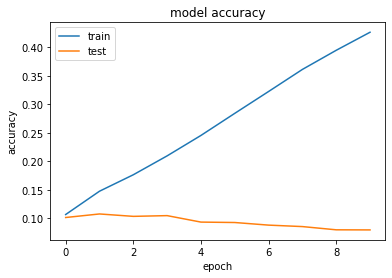

In [15]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

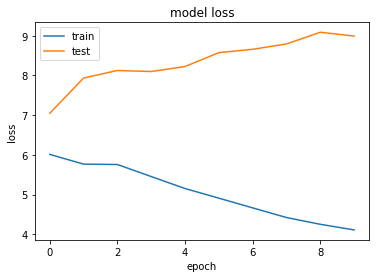

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#Prediction

In [17]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [18]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [19]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [20]:
q =  "There is nothing more deceptive than an obvious fact"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  There is nothing more deceptive than an obvious fact
Sequence:  there is nothing more deceptive
there
is
nothing
more
deceptive
next possible words:  ['than', 'i', 'but', 'for', 'your']
